# I - Création des tfrecord train et test

## 1 - paramètres :

In [18]:
path_od_csv = '/tf/ship_detect_tl/data_parsing/CSV/train_ship_segmentations_OD.csv'
path_h_csv = '/tf/ship_detect_tl/data_parsing/CSV/boats_hash.csv'
path_cluster_csv = '/tf/ship_detect_tl/data_parsing/CSV/clusters_sizes.csv'
imgs_dir = '/tf/ship_data/train_v2'
boat_rate = 0.7 # taux d'images contenant au moins un bateau
cut_rate = 0.8 # taux d'images (par rapport à nb_images) utilisées pour train. Le reste sera utilisé pour test.
tfrecord_dir = '/tf/ship_data/annotations' # répertoire où train et test seront créés

## 2 - exécution du script :

Génère deux fichiers au format tfrecord dans le répertoire tfrecord_dir : deux fichiers train et test nommés selon train_70_80.tfrecord pour 70% d'images avec bateau réparties 80% dans train, le reste dans test.
Génère également un fichier "metadata.txt" avec des informations concernant les base crées, les CSV des images présentes dans train et test au format pascal VOC ainsi que les distribution de tailles de nos deux bases.

Création des dataframes train et test...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3720/3720 [00:45<00:00, 81.00it/s]


Création de la distribution de tailles de bboxs de la base train (pdf)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14267/14267 [00:10<00:00, 1311.98it/s]


Création de la distribution de tailles de bboxs de la base test (pdf)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5857/5857 [00:04<00:00, 1321.50it/s]


Création du tfrecord train...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14220/14220 [00:45<00:00, 312.21it/s]


Création du tfrecord test...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3720/3720 [00:05<00:00, 656.20it/s]


Tfrecords créés avec succès !
Enregistrés dans le répertoire : /tf/ship_data/annotations/70_80


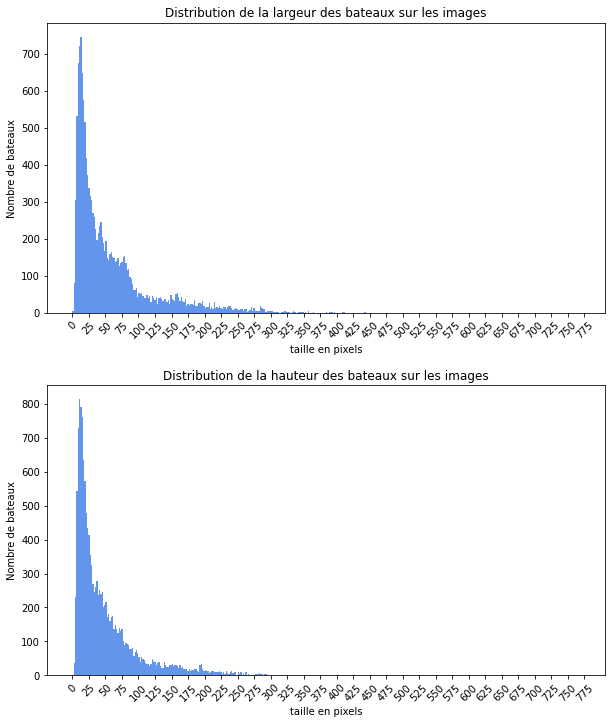

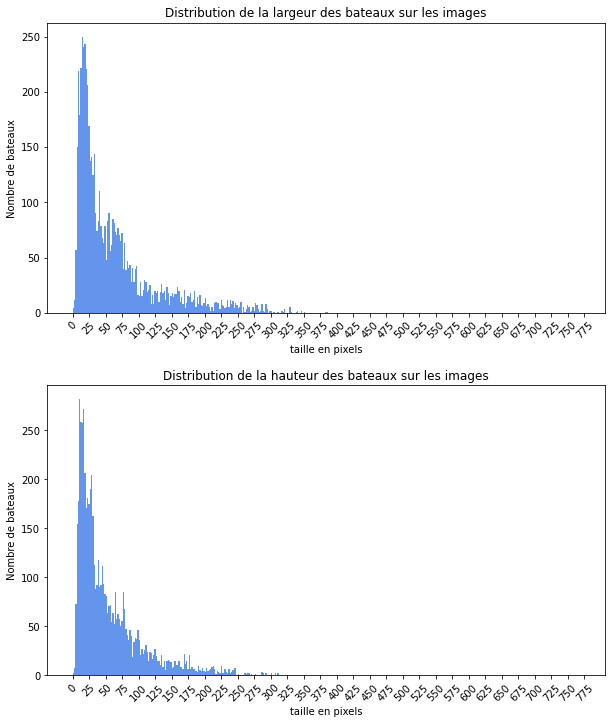

In [6]:
from generate_tfrecord import generate_tf_record
generate_tf_record(path_od_csv, path_h_csv, path_cluster_csv, imgs_dir, cut_rate, boat_rate, tfrecord_dir)

# II - Chargement du modèle

## 1 - paramètres :

Les modèles sont importés du "model zoo" de tensorflow : https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md

In [19]:
models_dir = '/tf/pretrained_models' # répertoire où les models seront téléchargés
model_url = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet101_v1_1024x1024_coco17_tpu-8.tar.gz'

## 2 - exécution du script :

In [10]:
from download_model import download_model
download_model(model_url, models_dir)

212156416/212150153 [==============================] - 3s 0us/step


# III - Paramétrage des hyperparamètres du modèle

Le paramétrage suivant n'est pas exhaustif. Seuls les paramètres génériques, assurant à l'apprentissage puisse être lancé. D'autres hyperparamètres spécifiques au modèle choisi (generations des "anchor boxes" par exemple) doivent également être paramétrés.

##  1 - choix des paramètres

In [15]:
config_dict = {
    'num_classes' : 1,
    'batch_size' : 48,
    'train_tfrecord_path' : '/tf/ship_data/annotations/70_80/train_aug_70_80.tfrecord',
    'test_tfrecord_path' : '/tf/ship_data/annotations/70_80/test_70_80.tfrecord',
    'label_map_path' : '/tf/ship_detect_tl/data/label_map.txt',
    'fine_tune_checkpoint' : '/tf/pretrained_models/checkpoints/faster_rcnn_resnet50_v1_1024x1024_coco17_tpu-8/checkpoint/ckpt-0',
    'fine_tune_checkpoint_type' : "detection"
    
}

## 2 -  Ecrire ces paramètres dans le fichier config

In [16]:
pipeline_config_path = '/tf/custom_models/faster_rcnn_resnet50_1024_3/pipeline.config'

In [17]:
from modify_pipeline import modify_pipeline
modify_pipeline(pipeline_config_path, config_dict)

INFO:tensorflow:Writing pipeline config file to /tf/custom_models/faster_rcnn_resnet50_1024_3/pipeline.config


[08/23 08:56:59] tensorflow INFO: Writing pipeline config file to /tf/custom_models/faster_rcnn_resnet50_1024_3/pipeline.config


### modifier à la main dans le fichier config :

scales: [0.17109284, 0.34188799, 0.05408635, 0.56590215]\
aspect_ratios: [1.49923858, 0.75238974, 2.61692419, 4.38809159]

Ces tailles de bboxs sont celles determinées par clustering. Voir le *notebook EDA_of_bbox* dans le dossier *tools*.

# IV - Génération des commandes pour lancer l'entrainement et l'évaluation

Il s'agira de copier ses commandes et de les coller dans le terminal de la machine où l'on souhaite lancer l'entrainement. 
Autrement dit, ces commandes doivent être exécutées dans le container paramétré selon la procédure décrite dans le tutoriel *tuto_image_docker* dans le dossier *tutorials*.
Ensuite, pour pouvoir avoir deux courbes (entrainement et validation), il faut exécuter les commande d'entrainement et de test en parallèle dans deux terminaux (dans le container). De plus, il est nécéssaire de veiller à allouer les ressources GPU de sorte que le calcul de la validation soit terminé avant l'arrivée du prochain checkpoint (on peut aussi jouer sur d'autres paramètres tels que la taille du dataset test, le nombre de steps avant d'écrire un checkpoint ou encore le nombre d'images testées dans le dataset tes).

## 1 -  Entrainement

### Allocation des ressources GPU (voir paragraphe précédent)

Dans le terminal du container dans lequel sera exécuté l'entrainement, coller (ex. si l'on choisit les GPU 0,1 et 2) : export CUDA_VISIBLE_DEVICES=0,1,2,3,4,5,6

### Commande pour l'entrainement

In [10]:
model_dir = '/tf/custom_models/faster_rcnn_resnet50_1024_3/checkpoint'
pipeline_config_path = '/tf/custom_models/faster_rcnn_resnet50_1024_3/pipeline.config'
num_train_steps = '25000'

Copier coller la commande affichée après exécution de la cellule suivante dans le terminal du container dans lequel sera exécuté l'entrainement.

In [11]:
command = 'python /tf/models/research/object_detection/model_main_tf2.py --model_dir={} --pipeline_config_path={} --num_train_steps={} --alsologtostderr'.format(model_dir, pipeline_config_path, num_train_steps)
print(command)

python /tf/models/research/object_detection/model_main_tf2.py --model_dir=/tf/custom_models/faster_rcnn_resnet50_1024_3/checkpoint --pipeline_config_path=/tf/custom_models/faster_rcnn_resnet50_1024_3/pipeline.config --num_train_steps=25000 --alsologtostderr


## 2 -  Validation

### Allocation des ressources GPU

Dans le terminal du container dans lequel sera exécuté l'entrainement, coller (ex. si l'on choisit les GPU 3) : export CUDA_VISIBLE_DEVICES=7

### Commande pour la validation

In [12]:
checkpoint_dir = model_dir
sample_1_of_n_eval_examples = '1'

Copier coller la commande affichée après exécution de la cellule suivante dans le terminal du container dans lequel sera exécuté l'entrainement.

In [13]:
command = 'python /tf/models/research/object_detection/model_main_tf2.py --model_dir={} --pipeline_config_path={} --checkpoint_dir={} --sample_1_of_n_eval_examples={}'.format(model_dir, pipeline_config_path, checkpoint_dir, sample_1_of_n_eval_examples)
print(command)

python /tf/models/research/object_detection/model_main_tf2.py --model_dir=/tf/custom_models/faster_rcnn_resnet50_1024_3/checkpoint --pipeline_config_path=/tf/custom_models/faster_rcnn_resnet50_1024_3/pipeline.config --checkpoint_dir=/tf/custom_models/faster_rcnn_resnet50_1024_3/checkpoint --sample_1_of_n_eval_examples=1


# V - observation des résultats 

Les courbes sont observables sous Tensorboard. Pour le lancer, il faudra exécuter la commande suivante dans le terminal du container. Puisque Tensorboard va tourner sur l'adresse locale du container, il ne sera pas accessible depuis l'ordinateur hôte. Il faut mettre en place du port forwarding voir établir un tunnel ssh si le container tourne sur un server. Cependant, pas d'inquiétude ! Si le container est ouvert sur VSCode, ce dernier va s'en occuper pour nous.

In [10]:
print('tensorboard --logdir {} --host 0.0.0.0'.format(model_dir))

tensorboard --logdir /tf/custom_models/faster_rcnn_resnet101_v1_1024x1024_coco17_tpu-8/checkpoint --host 0.0.0.0
